In [1]:
import os, pandas as pd, numpy as np, seaborn as sns

pd.set_option('display.max_columns', 50) # How many to show
pd.set_option('display.min_rows', 25) # How many to show
pd.set_option('display.max_rows', 25) # How many to show
pd.set_option('display.width', 1000) # How far across the screen
pd.set_option('display.max_colwidth', 100) # Column width in px
pd.set_option('expand_frame_repr', True) # allows for the representation of dataframes to stretch across pages, wrapped over the full column vs row-wise

from matplotlib import pyplot as plt 
from sklearn.metrics import confusion_matrix
from dotenv import load_dotenv
print(os.getcwd())

# Optional below

load_dotenv('../.env_analysis')

### If all else fails
# PROJECT_INPUT_DATA_DIR="/sddata/app_or_generated_data/Image-Comparator-Analysis/raw_annotations/arvo_abstract_flicker_12_06_2023
# PROJECT_DIR="/sddata/app_or_generated_data/Image-Comparator-Analysis/analysis/flicker_abstract_results_12_07_2023

DATA_DIR=os.environ["DATA_DIR"]
PROJECT_DIR=os.environ["PROJECT_DIR"]
PROJECT_INPUT_DATA_DIR=os.environ["PROJECT_INPUT_DATA_DIR"]
DNS=os.environ["DNS"]
IMAGES_DB=os.environ["IMAGES_DB"]
DB_PORT=os.environ["DB_PORT"]
DB_ADMIN_USER=os.environ["DB_ADMIN_USER"]
DB_ADMIN_PASS=os.environ["DB_ADMIN_PASS"]
ADMIN_PARTY=True if os.environ["ADMIN_PARTY"] == 'True' else False

print(f"""
DATA_DIR: {DATA_DIR}
PROJECT_DIR: {PROJECT_DIR}
PROJECT_INPUT_DATA_DIR: {PROJECT_INPUT_DATA_DIR}
DNS: {DNS}
IMAGES_DB: {IMAGES_DB}
DB_PORT: {DB_PORT}
DB_ADMIN_USER: {DB_ADMIN_USER}
DB_ADMIN_PASS: {DB_ADMIN_PASS}
ADMIN_PARTY: {ADMIN_PARTY}
""")



/sddata/projects/Image-Comparator-Anaylsis/analysis

DATA_DIR: 
PROJECT_DIR: /sddata/app_or_generated_data/Image-Comparator-Analysis/analysis/flicker_abstract_results_12_07_2023
PROJECT_INPUT_DATA_DIR: /sddata/app_or_generated_data/Image-Comparator-Analysis/raw_annotations/arvo_abstract_flicker_12_06_2023
DNS: qtimview.southcentralus.cloudapp.azure.com
IMAGES_DB: image_comparator
DB_PORT: 5984
DB_ADMIN_USER: admin
DB_ADMIN_PASS: los_gehts
ADMIN_PARTY: False



Read in everyone's annotations:

In [2]:
# image key
image_key = pd.read_csv(os.path.join(PROJECT_INPUT_DATA_DIR, "app_image_key.csv"))
image_key.sort_values('index', inplace=True)
image_key['image_id'] = image_key['relative_path'] + "_" + image_key['image']

# Scott's Model and EHR
flicker_registered_stable = pd.read_csv(os.path.join(PROJECT_INPUT_DATA_DIR, "flicker_registered_stable.csv"))
flicker_registered_stable.rename(columns={"fixed_img_path":"image_1_id", "moving_img_path":"image_2_id"}, inplace=True)

EHR_stable = flicker_registered_stable.loc[:,["image_1_id","image_2_id","gt_cdr_before","gt_cdr_after"]]; EHR_stable.rename(columns={"gt_cdr_before":"CDR_1","gt_cdr_after":"CDR_2"}, inplace=True)
Segformer_stable = flicker_registered_stable.loc[:,["image_1_id","image_2_id","pred_cdr_before","pred_cdr_after"]]; Segformer_stable.rename(columns={"gt_cdr_before":"CDR_1","gt_cdr_after":"CDR_2"}, inplace=True)

flicker_registered_mild_prog = pd.read_csv(os.path.join(PROJECT_INPUT_DATA_DIR, "flicker_registered_mild_prog.csv"))
flicker_registered_mild_prog.rename(columns={"fixed_img_path":"image_1_id", "moving_img_path":"image_2_id"}, inplace=True)

EHR_mild_prog = flicker_registered_mild_prog.loc[:,["image_1_id","image_2_id","gt_cdr_before","gt_cdr_after"]]; EHR_mild_prog.rename(columns={"gt_cdr_before":"CDR_1","gt_cdr_after":"CDR_2"}, inplace=True)
Segformer_mild_prog = flicker_registered_mild_prog.loc[:,["image_1_id","image_2_id","pred_cdr_before","pred_cdr_after"]]; Segformer_mild_prog.rename(columns={"gt_cdr_before":"CDR_1","gt_cdr_after":"CDR_2"}, inplace=True)

flicker_registered_sig_prog = pd.read_csv(os.path.join(PROJECT_INPUT_DATA_DIR, "flicker_registered_sig_prog.csv"))
flicker_registered_sig_prog.rename(columns={"fixed_img_path":"image_1_id", "moving_img_path":"image_2_id"}, inplace=True)

EHR_sig_prog = flicker_registered_sig_prog.loc[:,["image_1_id","image_2_id","gt_cdr_before","gt_cdr_after"]]; EHR_sig_prog.rename(columns={"gt_cdr_before":"CDR_1","gt_cdr_after":"CDR_2"}, inplace=True)
Segformer_sig_prog = flicker_registered_sig_prog.loc[:,["image_1_id","image_2_id","pred_cdr_before","pred_cdr_after"]]; Segformer_sig_prog.rename(columns={"gt_cdr_before":"CDR_1","gt_cdr_after":"CDR_2"}, inplace=True)


# classify
all_classify = pd.read_csv(os.path.join(PROJECT_INPUT_DATA_DIR, "all-v2_12_1_23-classify-0.csv"))
all_classify = pd.merge(image_key, all_classify, on="image_id")
all_classify.rename(columns={"Image":"CDR"}, inplace=True)

# compare
all_compare = pd.read_csv(os.path.join(PROJECT_INPUT_DATA_DIR, "all-v2_12_1_23-compare-0.csv"))
# flicker
all_flicker = pd.read_csv(os.path.join(PROJECT_INPUT_DATA_DIR, "all-v2_12_1_23-flicker-0.csv"))


## Stats to perform, maybe???

[*] Interater variability - raw CDR
  - Avg CDR by image even though there are 2 time points
  - Get each persons Estimated CDR by these images
  - plot is x-axis is average, and y-axis is estimated.
    * there might be images where avg was same value, this will allow for multiple estimated CDRs by person to show up on this average
  - Plot raters against each other
    * 


[] Rater v Scott's Model
  - 3 plots

[] Bar plots for each rater showing counts for categories of radio buttons
  - 3 plots


### Interater Variability

#### Expected v Average

In [3]:
mcnamast_classify = all_classify[all_classify['user'] == 'mcnamast']
gdeitz_classify = all_classify[all_classify['user'] == 'gdeitz']
swangyu_classify = all_classify[all_classify['user'] == 'swangyu']

In [4]:
# Compare Bins Created from Classify
average_classify = all_classify.groupby('image_id').mean("CDR"); average_classify.reset_index(inplace=True)
average_classify = pd.merge(image_key, average_classify, on="image_id")[["image_id","order","CDR"]]

average_first = average_classify[average_classify['order'] == "first"][['image_id', 'order','CDR']].reset_index()
average_first.rename(columns={"image_id":"image_1_id", "CDR":"CDR_1"}, inplace=True)
average_second = average_classify[average_classify['order'] == "second"][['image_id', 'order','CDR']].reset_index()
average_second.rename(columns={"image_id":"image_2_id", "CDR":"CDR_2"}, inplace=True)
average_side_by_side_cdrs = pd.concat([average_first, average_second], axis=1)

average_side_by_side_cdrs['CDR_Diff'] = abs(average_side_by_side_cdrs['CDR_1'] - average_side_by_side_cdrs['CDR_2'])
#### Wrong BINS BEING CALCULATED!!! sTEVE!!!!!!!!
average_side_by_side_cdrs['Choose CDR Desc'] = np.where((average_side_by_side_cdrs['CDR_Diff'] >= 0.0) & (average_side_by_side_cdrs['CDR_Diff'] < 0.15), 'Stable (CDR change 0.0)', 
                                               np.where((average_side_by_side_cdrs['CDR_Diff'] >= 0.15) & (average_side_by_side_cdrs['CDR_Diff'] < 0.3), 'Mild Progression (CDR change 0.00 - 0.15)', 
                                                                                                                                                         'Significant Progression (CDR change 0.15 - 0.3)'))
average_side_by_side_cdrs.sort_values(['image_1_id', 'image_2_id'], inplace=True)
average_side_by_side_cdrs.head(20)

,index,image_1_id,order,CDR_1,index,image_2_id,order,CDR_2,CDR_Diff,Choose CDR Desc
9,18,flicker_fixed_mild_prog_114_axis01_4599_135545_201609270751548463477a72bf9c98b0d.png,first,0.733333,19,flicker_registered_mild_prog_114_axis01_4599_176138_20170801082050794841bb85d7af2dc3d.png,second,0.783333,0.050000,Stable (CDR change 0.0)
10,20,flicker_fixed_mild_prog_165_AxisUCH01_1408_65191_201410011051205404475cfbcfb7b7bab.png,first,0.816667,21,flicker_registered_mild_prog_165_axis01_1408_177921_2017081410190623452146c7827787b94.png,second,0.850000,0.033333,Stable (CDR change 0.0)
11,22,flicker_fixed_mild_prog_167_axis01_5625_157069_20170316094631023fc5dcae4ccac68ac.png,first,0.500000,23,flicker_registered_mild_prog_167_axis01_5625_221919_20180516140226073259923afc19e706f.png,second,0.550000,0.050000,Stable (CDR change 0.0)
12,24,flicker_fixed_mild_prog_30_AxisUCH01_3790_60863_20140807095603288acddf6fac0b5fe9f.png,first,0.433333,25,flicker_registered_mild_prog_30_axis01_3790_247983_20181017100434810fb5b2b31c1ec0d3d.png,second,0.400000,0.033333,Stable (CDR change 0.0)
13,26,flicker_fixed_mild_prog_33_axis01_4536_144180_20161206122652531e26dbea745d021c0.png,first,0.350000,27,flicker_registered_mild_prog_33_axis01_4536_302388_201909031213598075f2f7044110594e4.png,second,0.333333,0.016667,Stable (CDR change 0.0)
14,28,flicker_fixed_mild_prog_59_axis01_4620_151518_201702060823050644033effe232a7d4c.png,first,0.750000,29,flicker_registered_mild_prog_59_axis01_4620_305069_201909180810530999f806b8316a4c828.png,second,0.866667,0.116667,Stable (CDR change 0.0)
15,30,flicker_fixed_mild_prog_77_axis01_5113_273735_20190402145357881bd4832a2c597b0e7.png,first,0.416667,31,flicker_registered_mild_prog_77_axis01_5113_498891_202203290829092827f527de51b02ec5f.png,second,0.466667,0.050000,Stable (CDR change 0.0)
16,32,flicker_fixed_sig_prog_162_axis01_2866_171276_2017062615213178815a66ae03faaf28d.png,first,0.683333,33,flicker_registered_sig_prog_162_axis01_2866_335801_2020021012593587987f93b29a2e5499d.png,second,0.783333,0.100000,Stable (CDR change 0.0)
17,34,flicker_fixed_sig_prog_179_axis01_20230_268248_20190225144408224c258630c3d9dcc20.png,first,0.600000,35,flicker_registered_sig_prog_179_axis01_20230_362732_202008031448111427df1caa86dc69943.png,second,0.666667,0.066667,Stable (CDR change 0.0)
18,36,flicker_fixed_sig_prog_194_axis01_139_176697_20170803100030756108b1c779df62e44.png,first,0.633333,37,flicker_registered_sig_prog_194_axis01_139_267787_201902211045395228841e4b3105c349b.png,second,0.450000,0.183333,Mild Progression (CDR change 0.00 - 0.15)


In [5]:
print(f"""
shapes:
mcnamast: {mcnamast_classify.shape} 
gdeitz: {gdeitz_classify.shape} 
swangyu: {swangyu_classify.shape}
average: {average_classify.shape}
scotts_segformer:  #...
ehr:  #...
""")


shapes:
mcnamast: (40, 13) 
gdeitz: (40, 13) 
swangyu: (40, 13)
average: (40, 3)
scotts_segformer:  #...
ehr:  #...



In [6]:
mcnamast_classify.sort_values('image_id', inplace=True);
gdeitz_classify.sort_values('image_id', inplace=True);
swangyu_classify.sort_values('image_id', inplace=True);
average_classify.sort_values('image_id', inplace=True);

/tmp/ipykernel_3513498/3316517193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcnamast_classify.sort_values('image_id', inplace=True);
/tmp/ipykernel_3513498/3316517193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdeitz_classify.sort_values('image_id', inplace=True);
/tmp/ipykernel_3513498/3316517193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swangyu_classify.sort_values('image_id', inplace=True);


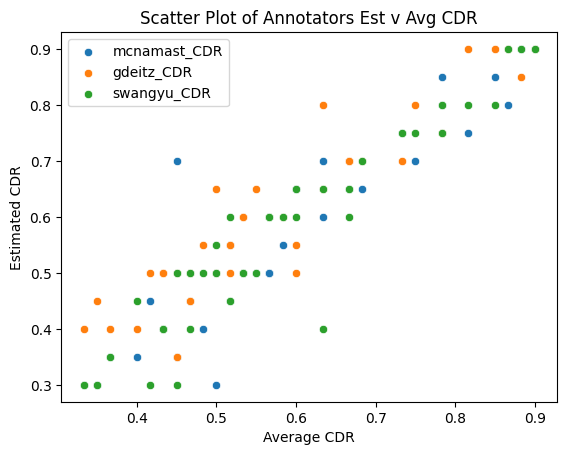

In [7]:
data_classify = pd.DataFrame({
"image_id": list(average_classify['image_id']),
"average_CDR": list(average_classify['CDR']),
"mcnamast_CDR": list(mcnamast_classify['CDR']),
"gdeitz_CDR": list(gdeitz_classify['CDR']),
"swangyu_CDR": list(swangyu_classify['CDR']),
})

sns.scatterplot(data=data_classify, x='average_CDR', y='mcnamast_CDR', label='mcnamast_CDR')
sns.scatterplot(data=data_classify, x='average_CDR', y='gdeitz_CDR', label='gdeitz_CDR')
sns.scatterplot(data=data_classify, x='average_CDR', y='swangyu_CDR', label='swangyu_CDR')


# Melt the DataFrame to create a single column for y-values and another for category labels
# melted_data = data.melt(id_vars=['image_id'], var_name='annotator', value_name='CDR')
# melted_data
# Create a scatter plot with different colors for each category
# sns.scatterplot(data=melted_data, x='average_CDR', y='CDR', hue='annotator')

# # # Customize the plot
plt.xlabel('Average CDR')
plt.ylabel('Estimated CDR')
plt.title('Scatter Plot of Annotators Est v Avg CDR')
plt.legend()

# Show the plot
plt.show()


#### Raters Against Each Other

TODO: Interrater agreement on the CDR is correlation coeff. and interrater agreement on stable, mild, sig is linear kappa for both flicker and compare.
Stacked bar chart for stable, mild, significant progression.

* average of cohen kappa when done on all rater combos for all classes.
  - 3 people combos for each compare and flicker = 6 kappas 
* then between raters filter for each category do was in agreement or not.
  - 3 people combos by 3 different classes by cmpare and flicker for  = 18 kappas.

In [8]:
# Scott's Model OLD
# ...pending

# Scott's Model NEW
# ...pending

# EHR
# ...pending


# Classify
average_side_by_side_cdrs

# Compare
mcnamast_compare = all_compare[all_compare['user'] == 'mcnamast']
gdeitz_compare = all_compare[all_compare['user'] == 'gdeitz']
swangyu_compare = all_compare[all_compare['user'] == 'swangyu']

mcnamast_compare.sort_values(['image_1_id', 'image_2_id'], inplace=True)
gdeitz_compare.sort_values(['image_1_id', 'image_2_id'], inplace=True)
swangyu_compare.sort_values(['image_1_id', 'image_2_id'], inplace=True)
all_compare.sort_values(['image_1_id', 'image_2_id'], inplace=True)

# Flicker
mcnamast_flicker = all_flicker[all_flicker['user'] == 'mcnamast']
gdeitz_flicker = all_flicker[all_flicker['user'] == 'gdeitz']
swangyu_flicker = all_flicker[all_flicker['user'] == 'swangyu']

mcnamast_flicker.sort_values(['image_1_id', 'image_2_id'], inplace=True)
gdeitz_flicker.sort_values(['image_1_id', 'image_2_id'], inplace=True)
swangyu_flicker.sort_values(['image_1_id', 'image_2_id'], inplace=True)
all_flicker.sort_values(['image_1_id', 'image_2_id'], inplace=True)



/tmp/ipykernel_3513498/1980519640.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcnamast_compare.sort_values(['image_1_id', 'image_2_id'], inplace=True)
/tmp/ipykernel_3513498/1980519640.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdeitz_compare.sort_values(['image_1_id', 'image_2_id'], inplace=True)
/tmp/ipykernel_3513498/1980519640.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swangyu_compare.sort_values(['imag

In [9]:
mcnamast_compare['Choose CDR Desc']
gdeitz_compare['Choose CDR Desc']
swangyu_compare['Choose CDR Desc']

mcnamast_flicker['Choose CDR Desc']
gdeitz_flicker['Choose CDR Desc']
swangyu_flicker['Choose CDR Desc']

40                            Stable (CDR change 0.0)
41          Mild Progression (CDR change 0.00 - 0.15)
42    Significant Progression (CDR change 0.15 - 0.3)
43                            Stable (CDR change 0.0)
44                            Stable (CDR change 0.0)
45    Significant Progression (CDR change 0.15 - 0.3)
46          Mild Progression (CDR change 0.00 - 0.15)
47    Significant Progression (CDR change 0.15 - 0.3)
48                            Stable (CDR change 0.0)
49                            Stable (CDR change 0.0)
50          Mild Progression (CDR change 0.00 - 0.15)
51                            Stable (CDR change 0.0)
52          Mild Progression (CDR change 0.00 - 0.15)
53                            Stable (CDR change 0.0)
54                            Stable (CDR change 0.0)
55          Mild Progression (CDR change 0.00 - 0.15)
56                            Stable (CDR change 0.0)
57                            Stable (CDR change 0.0)
58                          

In [10]:
def make_confusing(ann1, ann2):
    # Create a confusion matrix
    cm = confusion_matrix(ann1['data']['Choose CDR Desc'], ann2['data']['Choose CDR Desc'], labels=['Stable (CDR change 0.0)', 'Mild Progression (CDR change 0.00 - 0.15)', 'Significant Progression (CDR change 0.15 - 0.3)'])
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Stable (CDR change 0.0)', 'Mild Progression (CDR change 0.00 - 0.15)', 'Significant Progression (CDR change 0.15 - 0.3)'],
                yticklabels=['Stable (CDR change 0.0)', 'Mild Progression (CDR change 0.00 - 0.15)', 'Significant Progression (CDR change 0.15 - 0.3)'])
    plt.xlabel(f"{ann2['ann']} Labels")
    plt.ylabel(f"{ann1['ann']} Labels")
    plt.title('Confusion Matrix')
    plt.show()


In [11]:
ann1 = {"ann": "mcnamara", "data": mcnamast_compare[['image_1_id', 'image_2_id', 'Choose CDR Desc']]}
ann2 = {"ann": "gdeitz", "data": gdeitz_compare[['image_1_id', 'image_2_id', 'Choose CDR Desc']]}
ann3 = {"ann": "swangyu", "data": swangyu_compare[['image_1_id', 'image_2_id', 'Choose CDR Desc']]}
ann4 = {"ann": "average_classify_cdrs", "data": average_side_by_side_cdrs[['image_1_id', 'image_2_id', 'Choose CDR Desc']]}

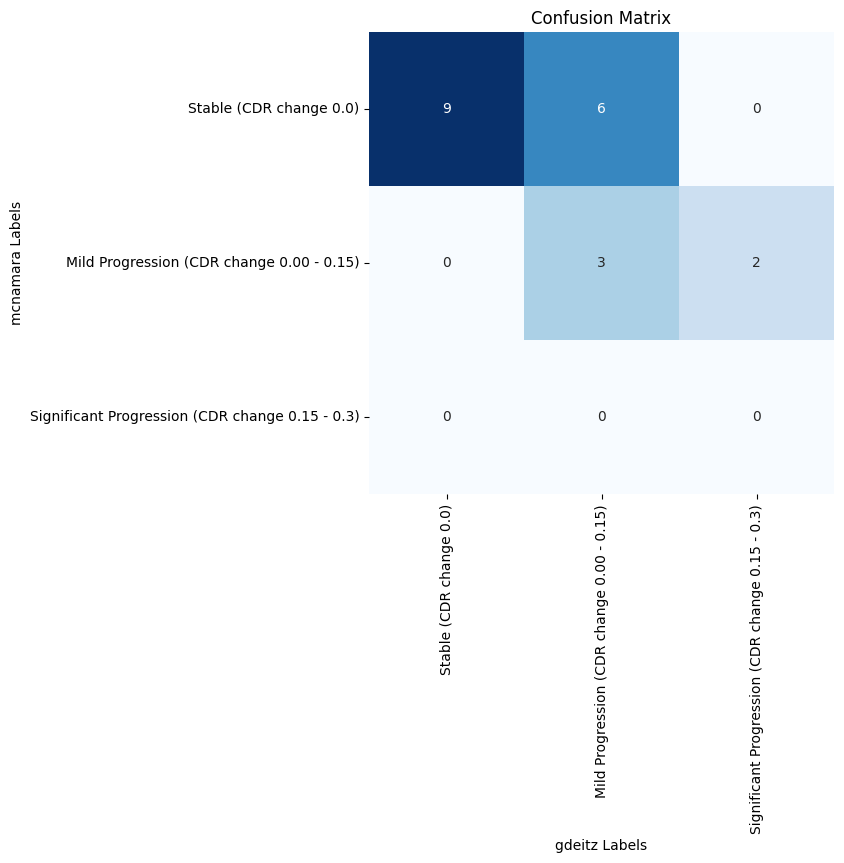

In [12]:
make_confusing(ann1, ann2)

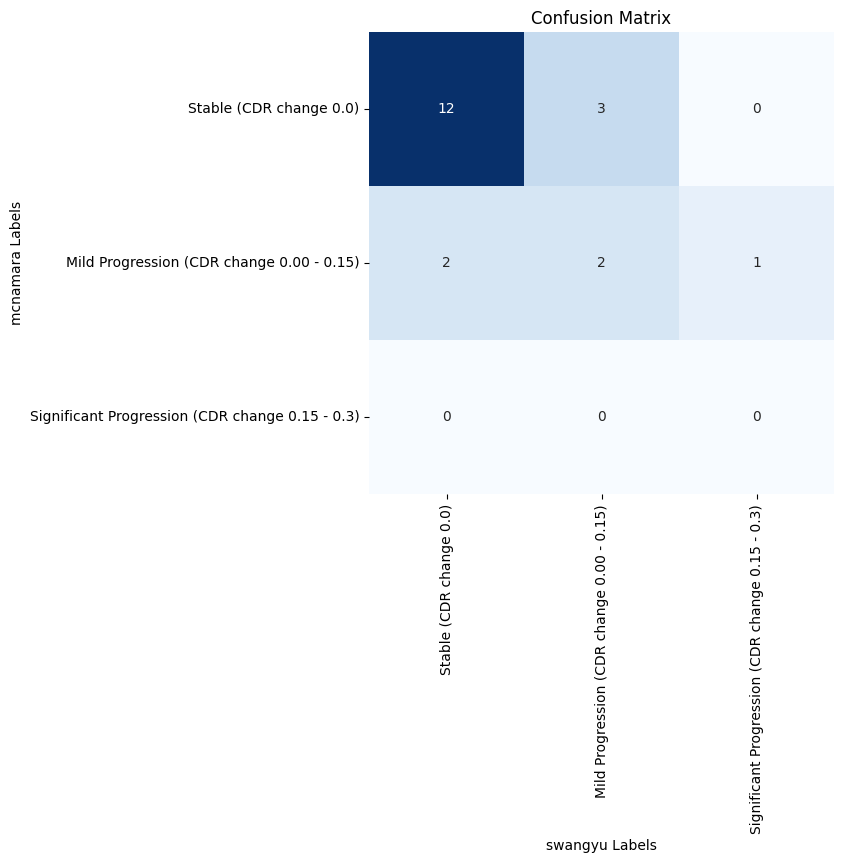

In [13]:
make_confusing(ann1, ann3)

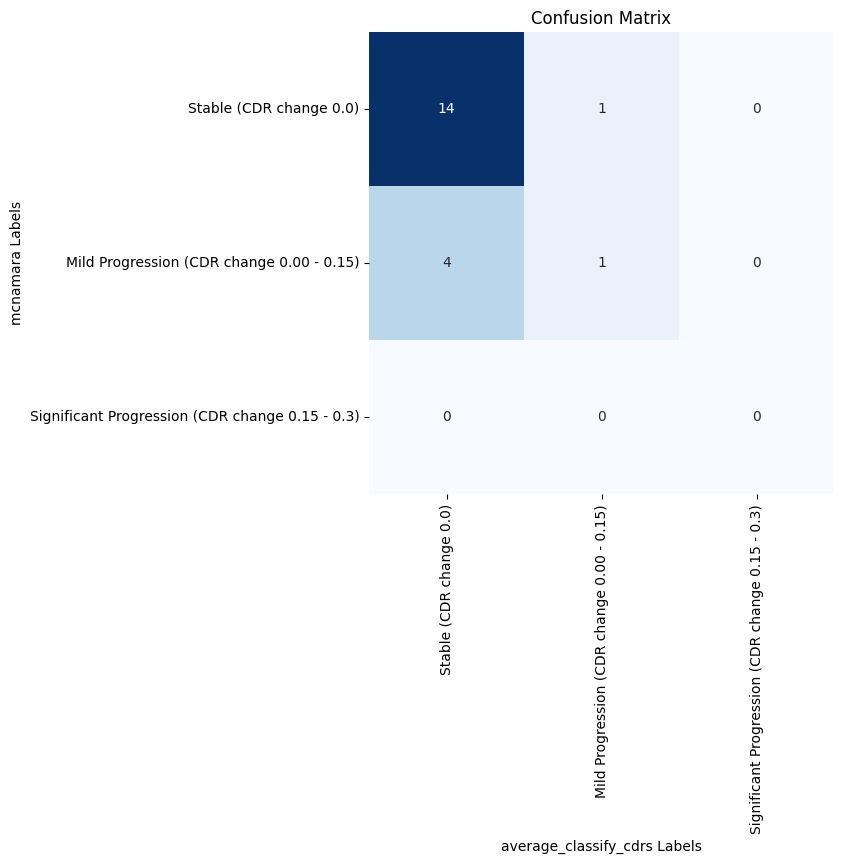

In [14]:
make_confusing(ann1, ann4)

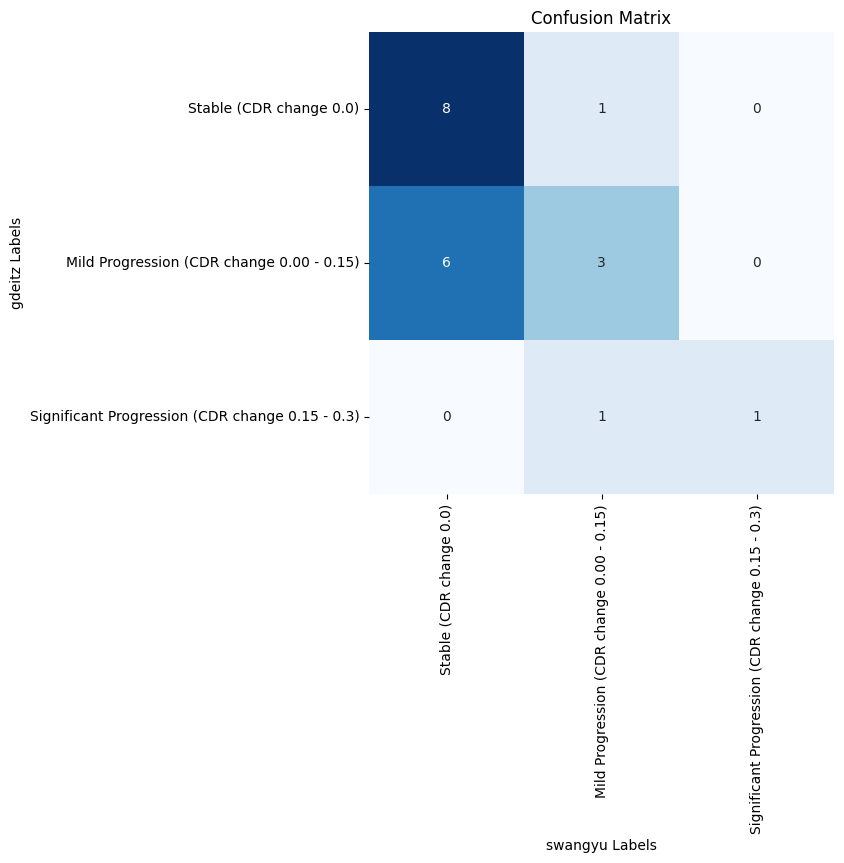

In [15]:
make_confusing(ann2, ann3)

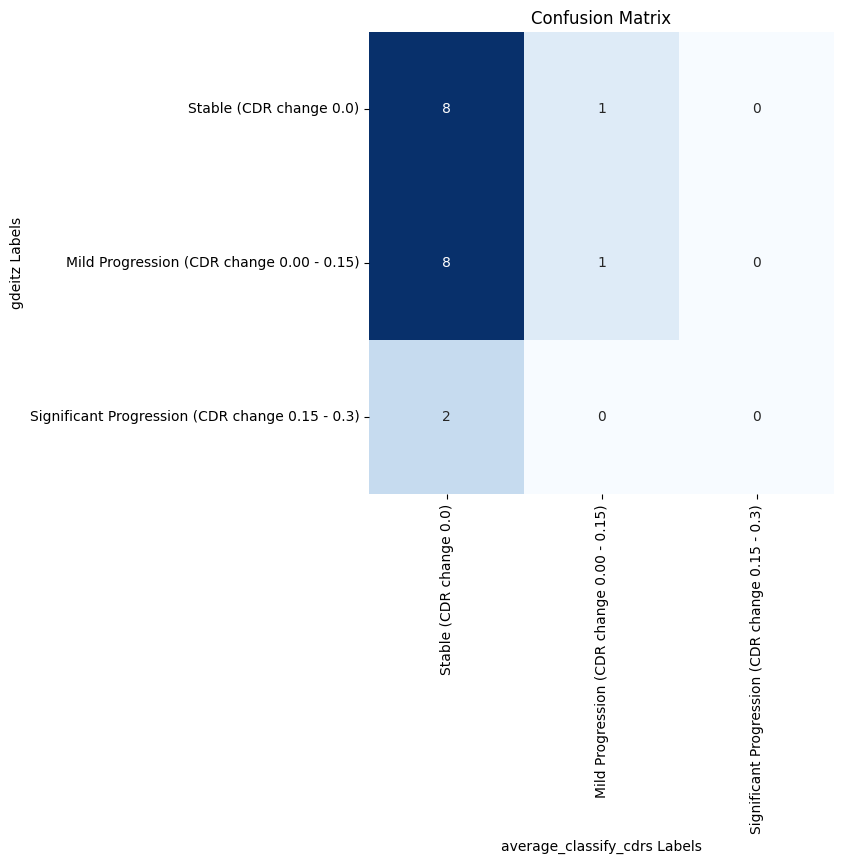

In [16]:
make_confusing(ann2, ann4)

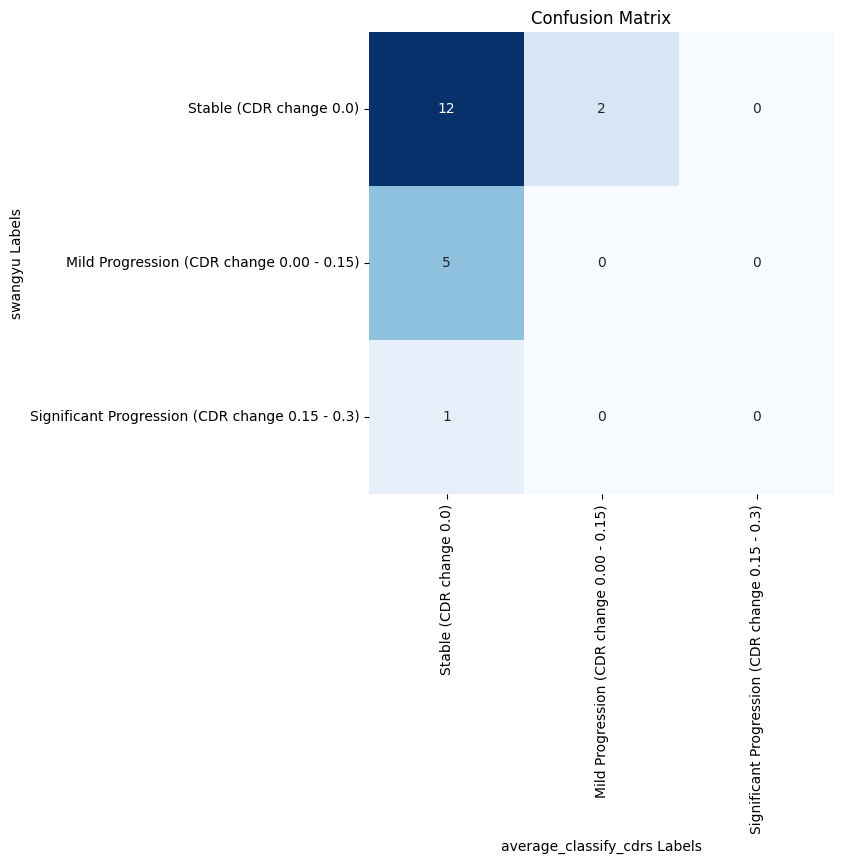

In [17]:
make_confusing(ann3, ann4)

In [18]:
ann1 = {"ann": "mcnamara", "data": mcnamast_flicker[['image_1_id', 'image_2_id', 'Choose CDR Desc']]}
ann2 = {"ann": "gdeitz", "data": gdeitz_flicker[['image_1_id', 'image_2_id', 'Choose CDR Desc']]}
ann3 = {"ann": "swangyu", "data": swangyu_flicker[['image_1_id', 'image_2_id', 'Choose CDR Desc']]}
ann4 = {"ann": "average_classify_cdrs", "data": average_side_by_side_cdrs[['image_1_id', 'image_2_id', 'Choose CDR Desc']]}

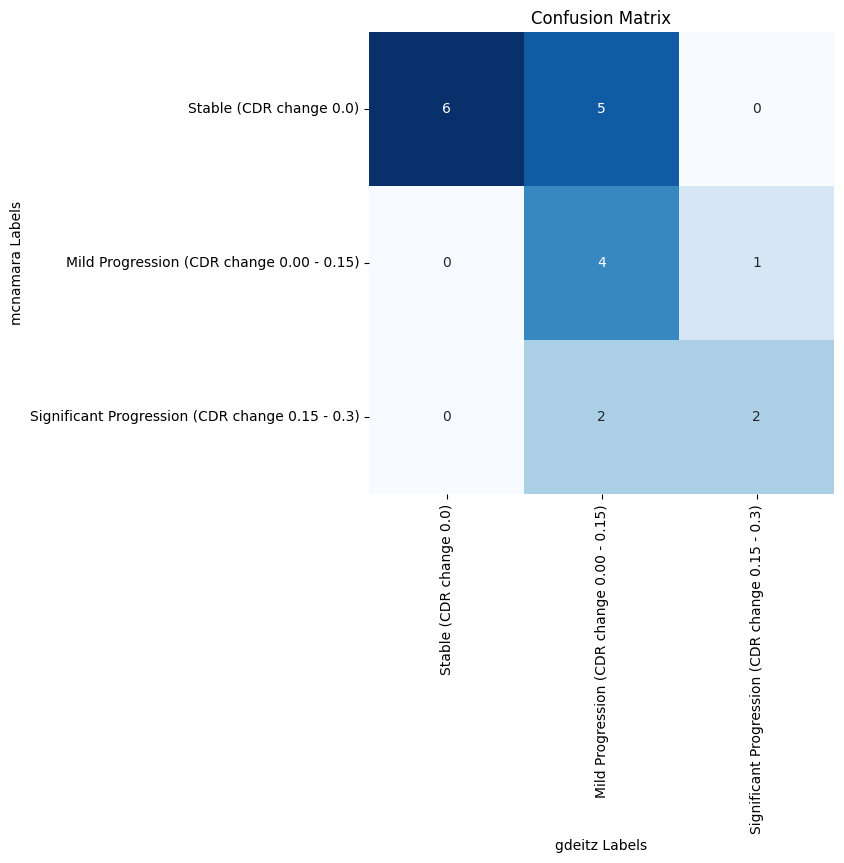

In [19]:
make_confusing(ann1, ann2)

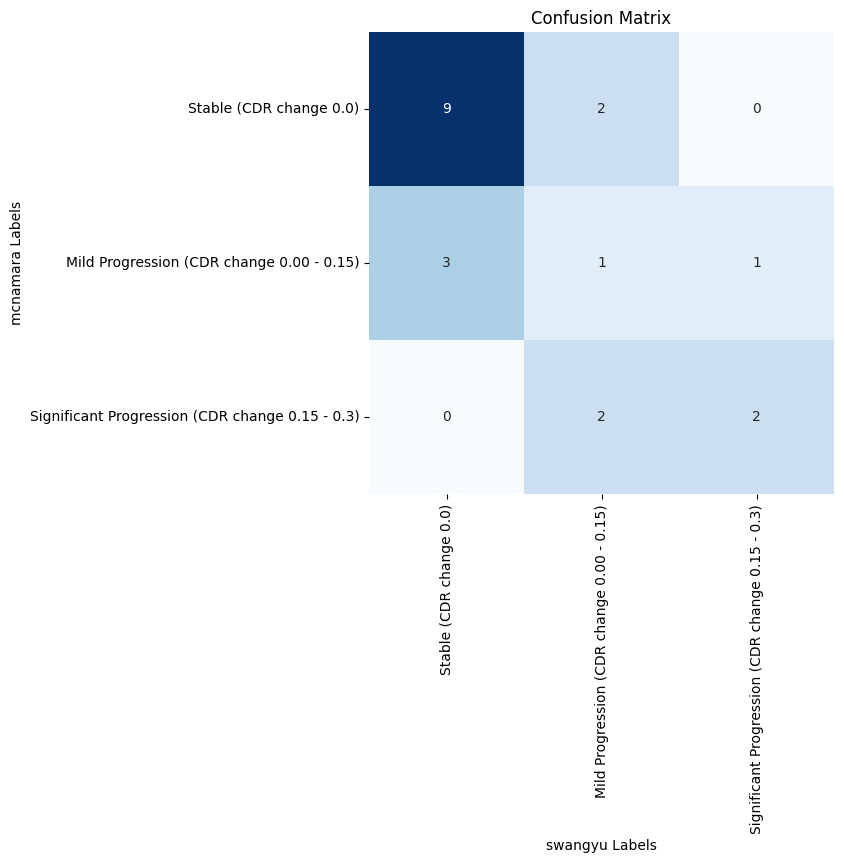

In [20]:
make_confusing(ann1, ann3)

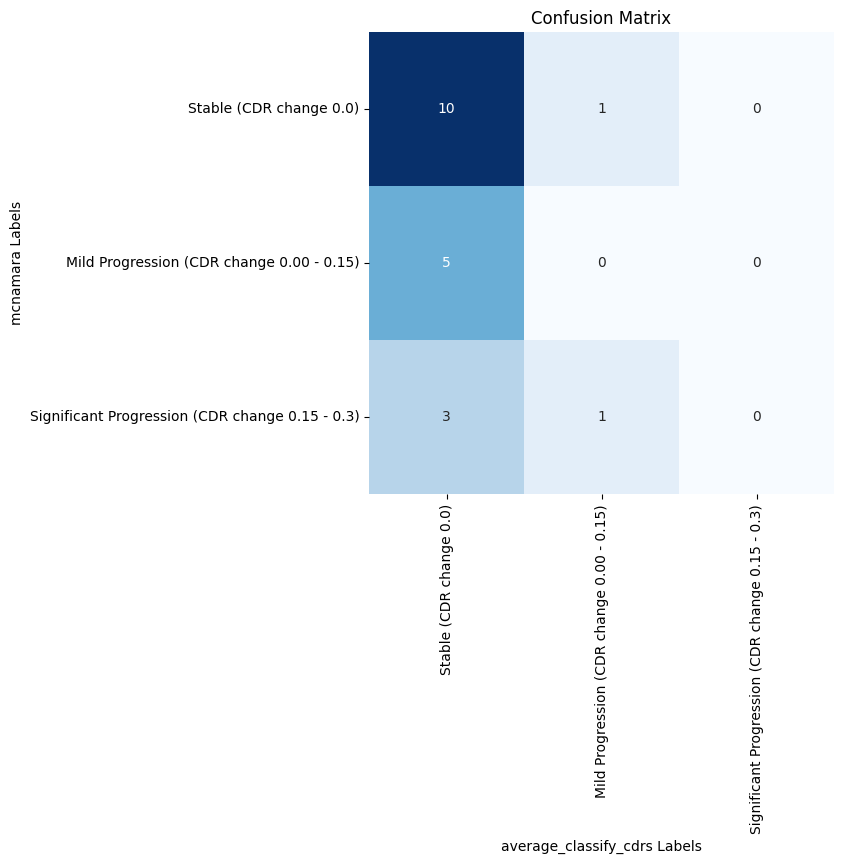

In [21]:
make_confusing(ann1, ann4)

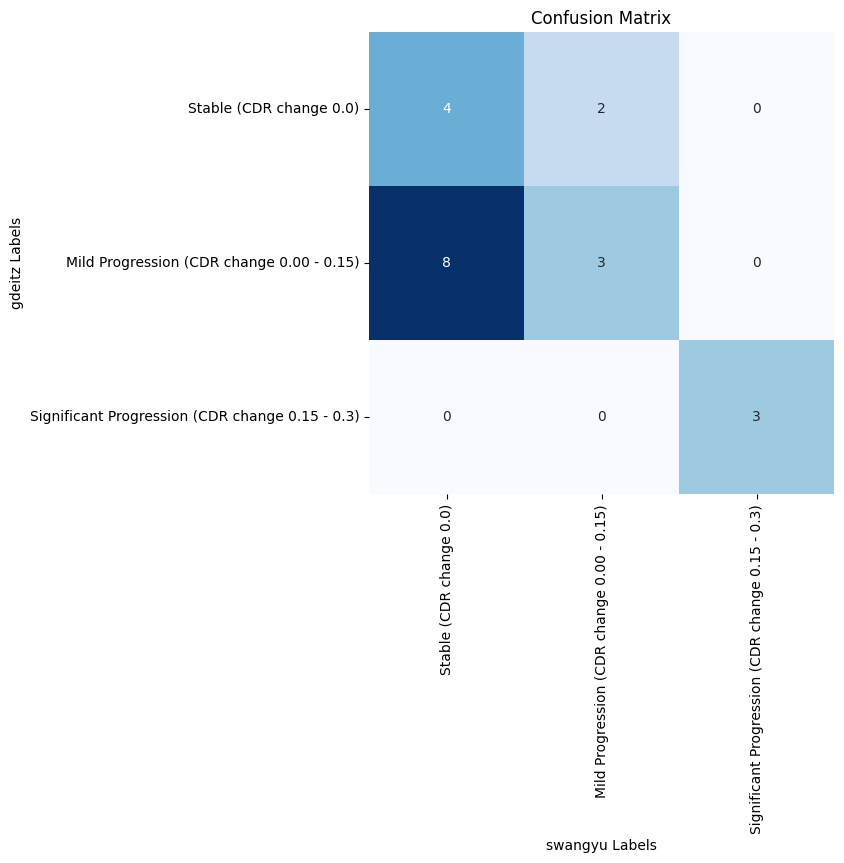

In [22]:
make_confusing(ann2, ann3)

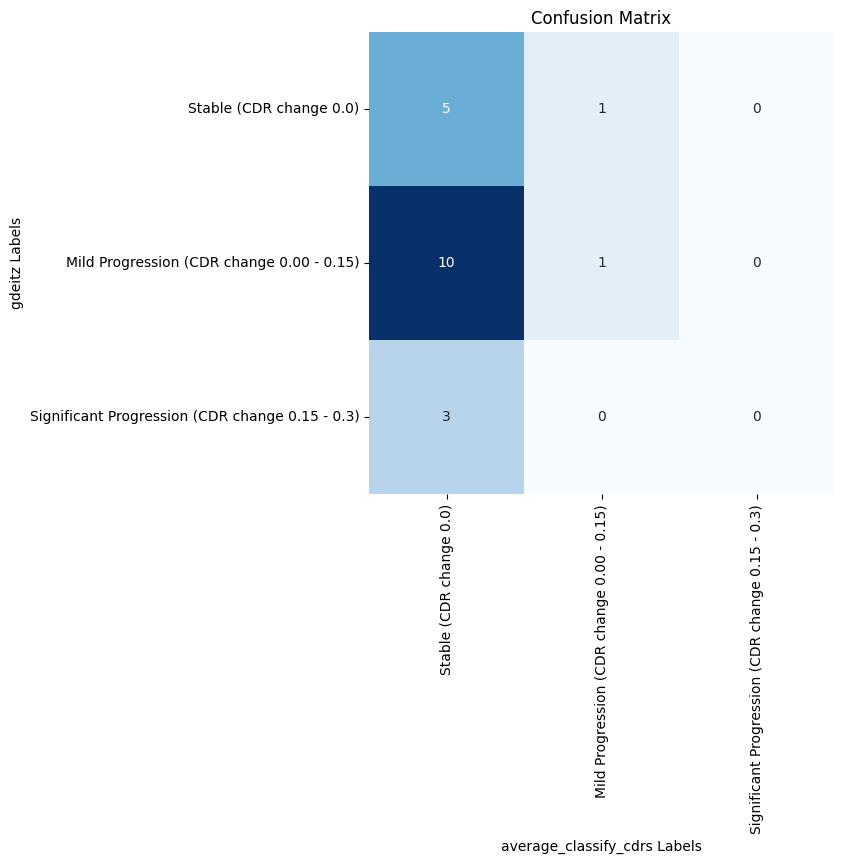

In [23]:
make_confusing(ann2, ann4)

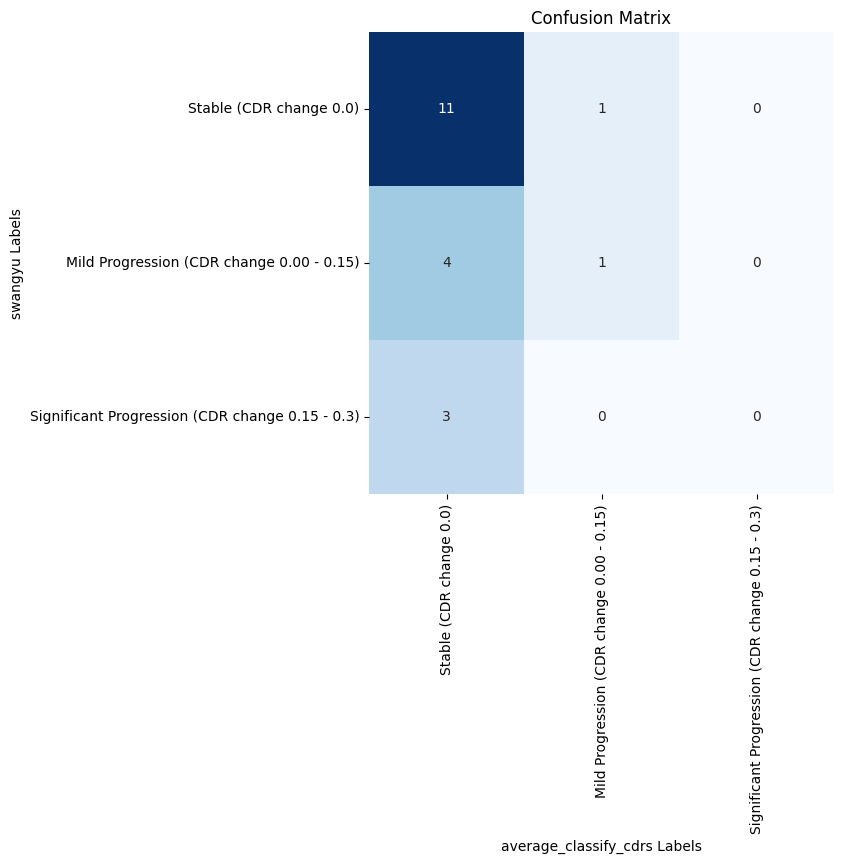

In [24]:
make_confusing(ann3, ann4)

### Boxes

We need the bar plot for all subdivided by annotator and stacked.

In [25]:

def plot_annotator_bar_plot(compare, flicker, annotator=""):
    data = pd.DataFrame({
        "Choose CDR Desc": list(compare['Choose CDR Desc']) + list(flicker['Choose CDR Desc']),
        "app": ["compare"]*len(compare[['taskid','Choose CDR Desc']]) + ["flicker"]*len(flicker[['taskid','Choose CDR Desc']])
    })

    # Create a countplot
    sns.set(style="whitegrid")
    ax = sns.countplot(data=data, x='Choose CDR Desc', hue='app')


    # Customize the plot
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title(f"Annotator {annotator} Bar Chart with 3 Categories, Compare v Flicker")
    plt.legend(title='Source')

    # Rotate x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed

    # Show the plot
    plt.show()


/tmp/ipykernel_3513498/3151096928.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed


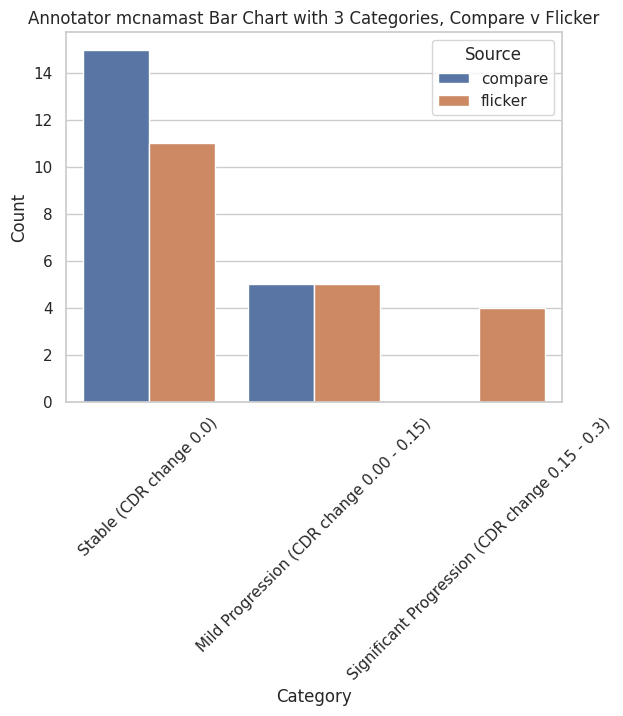

In [26]:
plot_annotator_bar_plot(mcnamast_compare, mcnamast_flicker, annotator="mcnamast")

/tmp/ipykernel_3513498/3151096928.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed


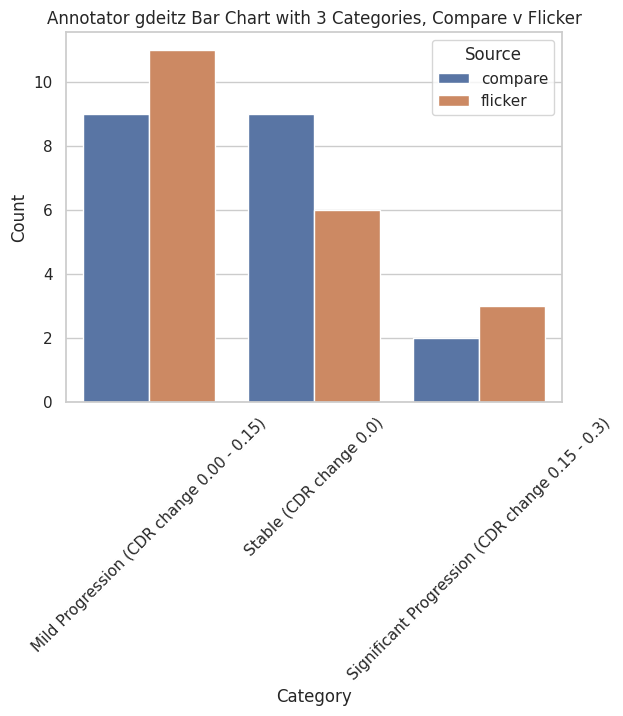

In [27]:
plot_annotator_bar_plot(gdeitz_compare, gdeitz_flicker, annotator="gdeitz")

/tmp/ipykernel_3513498/3151096928.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed


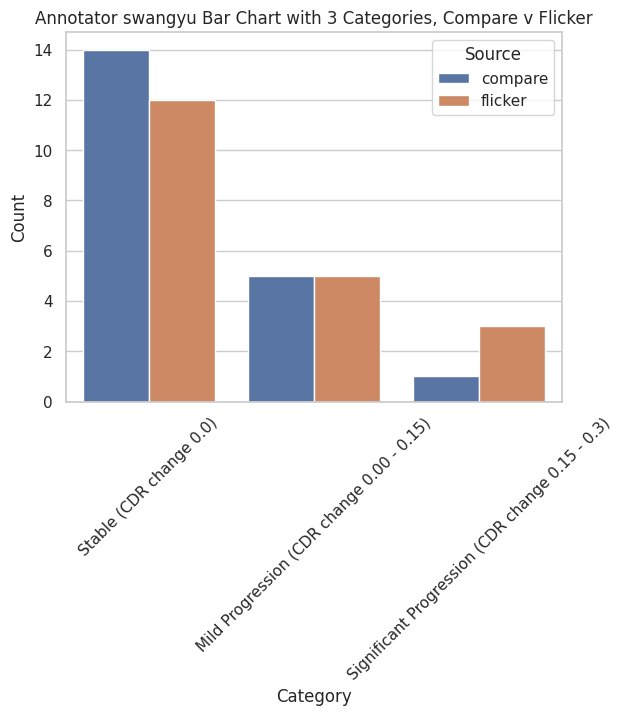

In [28]:
plot_annotator_bar_plot(swangyu_compare, swangyu_flicker, annotator="swangyu")

/tmp/ipykernel_3513498/3151096928.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed


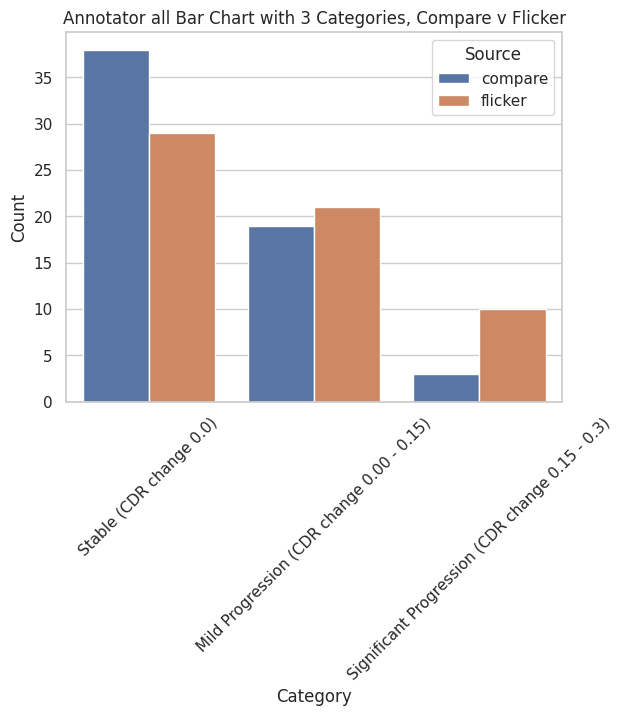

In [29]:
plot_annotator_bar_plot(all_compare, all_flicker, annotator="all")